# **Transfert learning**

In [1]:
import os  # Manipulations de fichiers
import shutil  # Pour supprimer un dossier non vide
import random  # Utilisé lors de la séparation train/test
from math import ceil  # Utilisé lors de la séparation train/test

# Désactivation des messages de debugging de tensorflow.
# Doit être exécuté avant les imports de tensorflow.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Préparation des données, création du modèle, data augmentation
from tensorflow import device
from tensorflow.config import list_physical_devices
from tensorflow.keras.utils import image_dataset_from_directory, set_random_seed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Modèle préentraîné VGG16
from tensorflow.keras.applications.vgg16 import VGG16

# Visualisations
import matplotlib.pyplot as plt

Création d'une seed pour stabiliser les résultats. Malgré ceci, les calculs réalisés à l'aide d'une carte graphique peuvent parfois amener un peu de variabilité.

In [2]:
seed = 42
# Paramétrer la seed de numpy, tensorflow et python : 
set_random_seed(seed)
random.seed(seed)

Séparation des images en train/test en créant un nouveau dossier.

In [3]:
split_ratio = 0.8

#input_folder = "dogs_small_proc"
#input_folder = "dogs_small_proc_white"
input_folder = "dogs_small"

output_folder = input_folder + "_splited"

# Nombre de sous dossiers, autrement dit : nombre de classe
# je mets cette valeur de côté, on en aura besoin pour la structure du modèle
nb_classes = len(os.listdir(input_folder))

# Si le dossier existe déjà
# suppression du dossier et de son contenu avec shutil
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Créer les dossiers train et test dans le dossier de sortie
train_folder = os.path.join(output_folder, 'train')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Parcourir les sous-dossiers du dossier d'origine
for label_folder in os.listdir(input_folder):
    label_path = os.path.join(input_folder, label_folder)
    if os.path.isdir(label_path):
        # Liste des fichiers dans le sous-dossier
        files = os.listdir(label_path)
        # Calculer le nombre de fichiers à utiliser pour l'entraînement
        train_count = ceil(len(files) * split_ratio)
        # Mélanger la liste des fichiers de manière aléatoire
        random.shuffle(files)
        
        # Diviser les fichiers entre train et test
        train_files = files[:train_count]
        test_files = files[train_count:]

        # Créer les sous-dossiers correspondants dans les dossiers train et test
        train_label_folder = os.path.join(train_folder, label_folder)
        test_label_folder = os.path.join(test_folder, label_folder)
        os.makedirs(train_label_folder, exist_ok=True)
        os.makedirs(test_label_folder, exist_ok=True)

        # Copier les fichiers dans les sous-dossiers correspondants
        for file in train_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(train_label_folder, file))
        
        for file in test_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(test_label_folder, file))

In [4]:
path = output_folder+"/train"
path_test = output_folder+"/test"


https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [5]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    #dataset = tf.keras.utils.image_dataset_from_directory(
    dataset = image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [6]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 472 files belonging to 3 classes.
Using 354 files for training.
Found 472 files belonging to 3 classes.
Using 118 files for validation.
Found 117 files belonging to 3 classes.


In [7]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(nb_classes, activation='softmax')  # nb_classes : nombre de classes
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [8]:
# Création du modèle
with device('/gpu:0'):    
    model = create_model_fct2()

# Création du callback
model_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [9]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
with device('/gpu:0'): 
    history = model.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.1240 - accuracy: 0.4153
Epoch 1: val_loss improved from inf to 0.87790, saving model to ./model_best_weights.h5
12/12 [==============================] - 4s 139ms/step - loss: 1.1240 - accuracy: 0.4153 - val_loss: 0.8779 - val_accuracy: 0.6356
Epoch 2/50


/home/maxime/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/12 [==========================>...] - ETA: 0s - loss: 0.9097 - accuracy: 0.5511
Epoch 2: val_loss improved from 0.87790 to 0.65758, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 84ms/step - loss: 0.9088 - accuracy: 0.5537 - val_loss: 0.6576 - val_accuracy: 0.8220
Epoch 3/50
11/12 [==========================>...] - ETA: 0s - loss: 0.7633 - accuracy: 0.6364
Epoch 3: val_loss improved from 0.65758 to 0.54117, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 85ms/step - loss: 0.7615 - accuracy: 0.6384 - val_loss: 0.5412 - val_accuracy: 0.8814
Epoch 4/50
11/12 [==========================>...] - ETA: 0s - loss: 0.6729 - accuracy: 0.7699
Epoch 4: val_loss improved from 0.54117 to 0.48461, saving model to ./model_best_weights.h5
12/12 [==============================] - 1s 89ms/step - loss: 0.6744 - accuracy: 0.7655 - val_loss: 0.4846 - val_accuracy: 0.8051
Epoch 5/50
12/12 [==============================] - ETA: 0s - l

In [11]:
# Score du dernier epoch

loss, accuracy = model.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

12/12 [==============================] - 1s 39ms/step - loss: 0.0533 - accuracy: 0.9887
Training Accuracy   : 0.9887

4/4 [==============================] - 0s 42ms/step - loss: 0.1644 - accuracy: 0.9492
Validation Accuracy :  0.9492


In [12]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  0.9661
Test Accuracy       :  0.9487


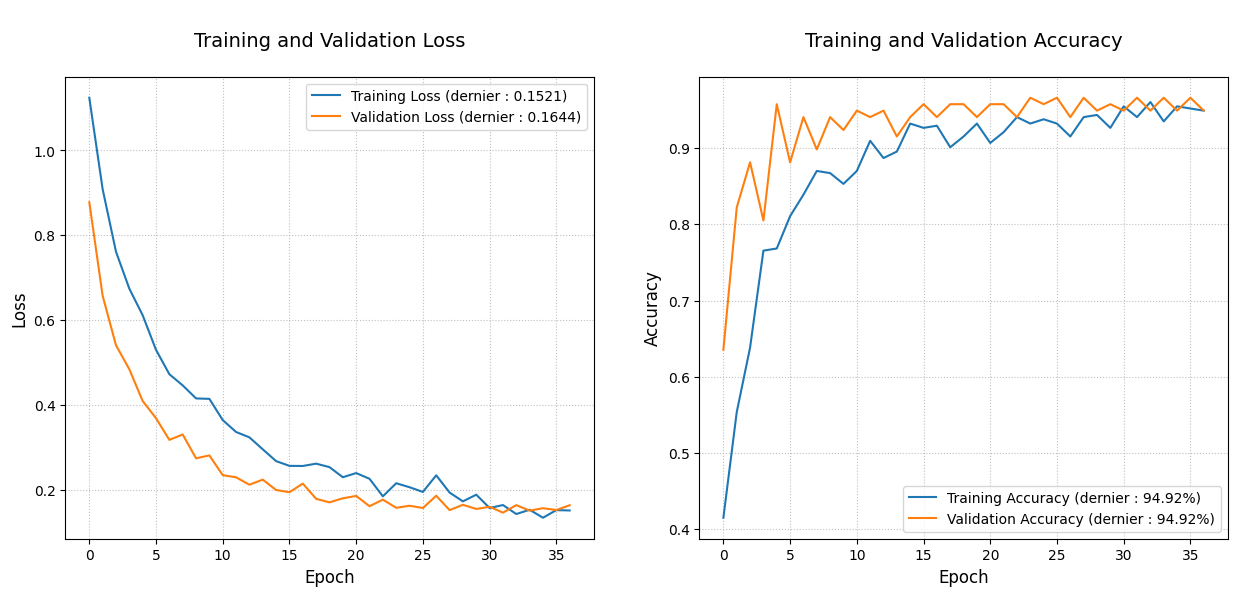

In [13]:
# Accéder au dictionnaire contenant les métriques
metrics_dict = history.history

# Graphique des résultats d'entraînement :
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Tracer la courbe de perte d'entraînement et de validation
ax1.plot(metrics_dict['loss'], label=f'Training Loss (dernier : {metrics_dict["loss"][-1]:.4f})')
ax1.plot(metrics_dict['val_loss'], label=f'Validation Loss (dernier : {metrics_dict["val_loss"][-1]:.4f})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.set_title('\nTraining and Validation Loss\n', fontsize=14)
ax1.grid(True, linestyle=':', alpha=0.8)

# Tracer la courbe d'accuracy d'entraînement et de validation
ax2.plot(metrics_dict['accuracy'], label=f'Training Accuracy (dernier : {metrics_dict["accuracy"][-1]*100:.2f}%)')
ax2.plot(metrics_dict['val_accuracy'], label=f'Validation Accuracy (dernier : {metrics_dict["val_accuracy"][-1]*100:.2f}%)')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.set_title('\nTraining and Validation Accuracy\n', fontsize=14)
ax2.grid(True, linestyle=':', alpha=0.8)

plt.show()